
# RNN: Prediksi Harga 

menggunakan SimpleRNN untuk memodelkan hubungan temporal dalam data harga pangan. Data diproses menjadi sekuens 12 bulan, dilatih dengan 300 epoch menggunakan optimizer Adam dan MSE, dan dievaluasi dengan grafik perbandingan aktual vs prediksi. Meskipun model menunjukkan konvergensi yang baik (loss turun ke ~0.0034), prediksi jangka panjang (2026–2027) dapat ditingkatkan dengan model seperti LSTM/GRU, penambahan fitur, dan validasi data terpisah.

In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
import datetime, os


In [11]:
DATA_PATH = "Rata-rata_Harga_Pangan_Bulanan_Tingkat_Produsen_Nasional (Angka April 2025).csv"
COMMODITY = "Beras Medium Tk. Penggilingan (Rp/Kg)"  # ubah sesuai kebutuhan
SEQUENCE_LENGTH = 12  # menggunakan 12 bulan terakhir untuk prediksi bulan berikutnya
EPOCHS = 300
BATCH_SIZE = 16

In [12]:
import pandas as pd
import numpy as np

# === BACA & BERSIHKAN DATA ===
# Skip metadata row (baris pertama)
raw_df = pd.read_csv(DATA_PATH, sep=";", skiprows=1)

# Hapus kolom kosong jika ada
raw_df = raw_df.loc[:, ~raw_df.columns.str.contains('^Unnamed')]

# Bersihkan kolom Harga: hilangkan 'Rp' dan titik, ubah ke int
raw_df['Harga'] = (raw_df['Harga']
                   .str.replace('Rp', '', regex=False)
                   .str.replace('.', '', regex=False)
                   .str.replace(',', '', regex=False)
                   .replace('-', np.nan)
                   .astype(float))            

# Peta nama bulan ke angka
month_map = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
    'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
    'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}
raw_df['MonthNum'] = raw_df['Bulan'].map(month_map)

# Buat kolom tanggal (gunakan hari pertama tiap bulan)
raw_df['Date'] = pd.to_datetime(dict(year=raw_df['Tahun'],
                                     month=raw_df['MonthNum'],
                                     day=1))

# Filter komoditas
df = raw_df[raw_df['Komoditas'] == COMMODITY].copy()
df = df.sort_values('Date').reset_index(drop=True)

# Tampilkan 5 data teratas
df.head()

,Komoditas,Tahun,Bulan,Harga,MonthNum,Date
0,Beras Medium Tk. Penggilingan (Rp/Kg),2019,Januari,9497.0,1.0,2019-01-01
1,Beras Medium Tk. Penggilingan (Rp/Kg),2019,Februari,9524.0,2.0,2019-02-01
2,Beras Medium Tk. Penggilingan (Rp/Kg),2019,Maret,9379.0,3.0,2019-03-01
3,Beras Medium Tk. Penggilingan (Rp/Kg),2019,April,9192.0,4.0,2019-04-01
4,Beras Medium Tk. Penggilingan (Rp/Kg),2019,Mei,9123.0,5.0,2019-05-01


In [13]:

# === NORMALISASI & PEMBUATAN SEKUENS ===
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(df[['Harga']])

# Buat fungsi untuk membuat dataset sekuens
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(prices_scaled, SEQUENCE_LENGTH)

# Bentuk akhir untuk RNN: (samples, time_steps, features)
print("Shape X:", X.shape, "Shape y:", y.shape)


Shape X: (64, 12, 1) Shape y: (64, 1)


In [14]:

# === MEMBANGUN & MELATIH MODEL RNN ===
model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(SEQUENCE_LENGTH, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Early stopping untuk mencegah overfitting
es = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[es])


Epoch 1/300


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1009
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0425
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0206
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0083
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0087
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0077
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061
Epoch 12/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073
Epoch 13/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 
Epoch 14/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061
Epoch 15/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 
Epoch 16/300
4/4 ━━━━━━━━━━━━━━

In [15]:

# === PREDIKSI 24 BULAN KE DEPAN ===
future_steps = 24  # 24 bulan = 2 tahun
last_sequence = prices_scaled[-SEQUENCE_LENGTH:]  # 12 bulan terakhir

predictions_scaled = []
input_seq = last_sequence.copy()

for _ in range(future_steps):
    pred_scaled = model.predict(input_seq.reshape(1, SEQUENCE_LENGTH, 1), verbose=0)[0][0]
    predictions_scaled.append(pred_scaled)
    # Perbarui input_seq
    input_seq = np.append(input_seq[1:], [[pred_scaled]], axis=0)

# Denormalisasi
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()

# Buat rangkaian tanggal untuk prediksi
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1),
                             periods=future_steps, freq='MS')

pred_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': predictions
})

pred_df.head()


,Date,Predicted_Price
0,2025-05-01,12485.770508
1,2025-06-01,12414.351562
2,2025-07-01,12432.339844
3,2025-08-01,12442.542969
4,2025-09-01,12371.561523


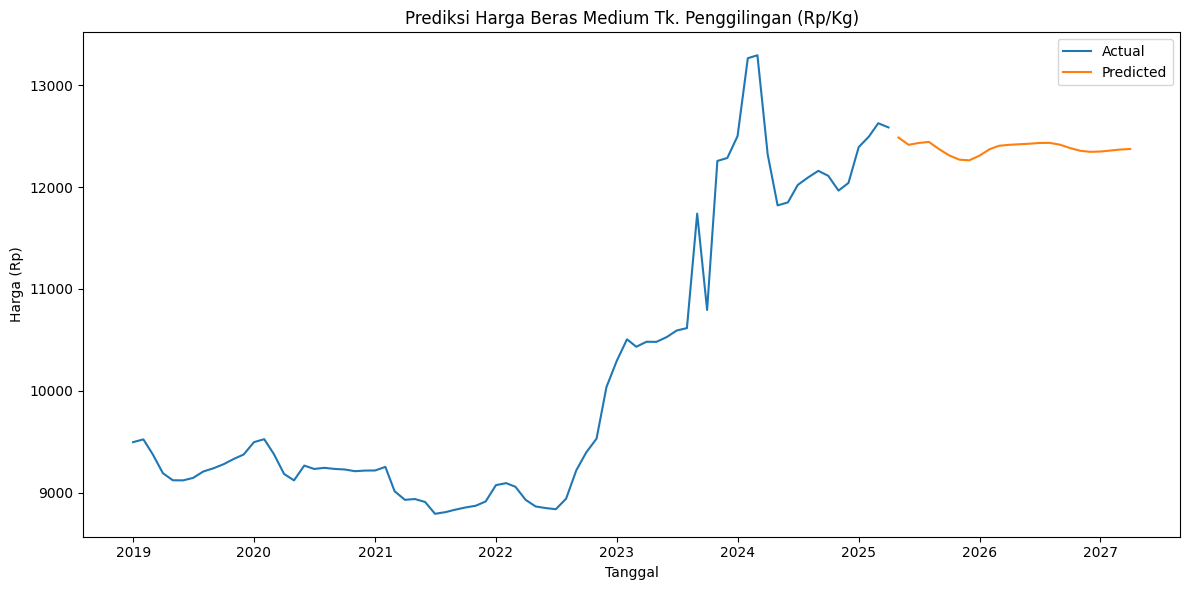

In [16]:

# === VISUALISASI ===
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Harga'], label='Actual')
plt.plot(pred_df['Date'], pred_df['Predicted_Price'], label='Predicted')
plt.title(f'Prediksi Harga {COMMODITY}')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.legend()
plt.tight_layout()
plt.show()


In [17]:

# === SIMPAN HASIL ===
output_csv = f"prediksi_{COMMODITY.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '')}.csv"
pred_df.to_csv(output_csv, index=False)
print(f"Prediksi disimpan ke {output_csv}")


Prediksi disimpan ke prediksi_Beras_Medium_Tk._Penggilingan_RpKg.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


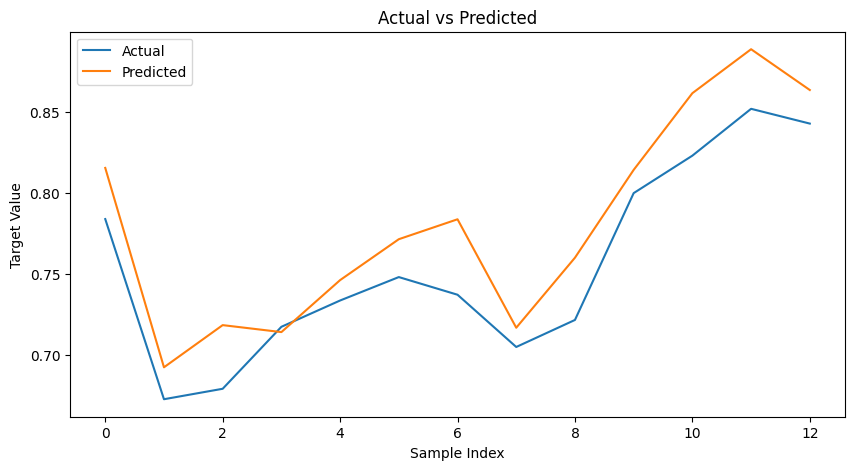

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


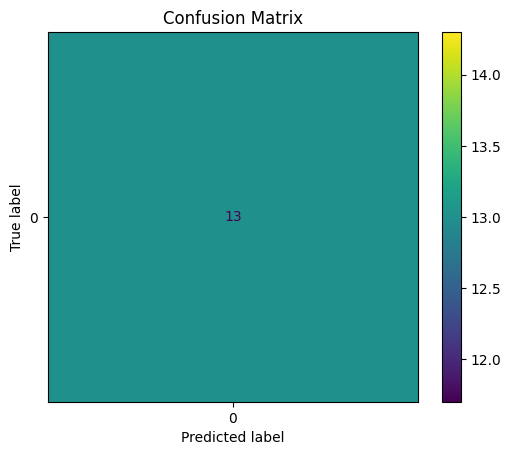

Accuracy: 1.0000


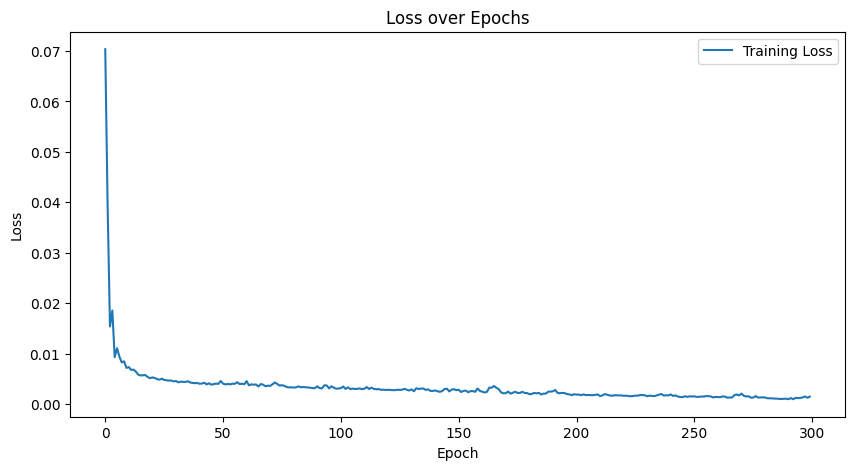

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,869 (50.27 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,580 (33.52 KB)

In [18]:

# === Evaluasi Model RNN ===

# Jika belum ada, pisahkan data menjadi training dan testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Asumsikan X dan y sudah tersedia
try:
    X_train, X_test, y_train, y_test
except NameError:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Prediksi hasil model
y_pred = model.predict(X_test)

# === RNN Outcomes: Plot Actual vs Predicted ===
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.show()

# === Confusion Matrix (jika klasifikasi) ===
try:
    y_pred_classes = (y_pred > 0.5).astype(int)
    y_test_bin = (y_test > 0.5).astype(int)
    cm = confusion_matrix(y_test_bin, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

    accuracy = accuracy_score(y_test_bin, y_pred_classes)
    print(f"Accuracy: {accuracy:.4f}")
except Exception as e:
    print("Confusion matrix tidak ditampilkan karena model ini kemungkinan regresi, bukan klasifikasi.")
    print("Detail:", e)

# === Grafik Loss dan Akurasi selama Pelatihan ===
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

if 'accuracy' in history.history:
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# === Tampilan Model RNN ===
model.summary()
